# 2023/07/18 made by SAWADA SHO in Kobe University, Dept. of Oceanology, Lab. of Sediment Hazards and Disaster Risk

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from natsort import natsorted
import os
from scipy import interpolate

In [3]:
#############
##MH法#######
#############

def MH(sample_list, iter, warmup, chains):   

    #尤素関数
    def Pi(theta, sample_list): 
        func = [(1/np.sqrt(2*np.pi))*np.exp(-(x-theta)**2/2) for x in sample_list]
        value = np.prod(func)
        return value

    #事前分布
    def f(theta):
        func = (1/np.sqrt(20000*np.pi))*np.exp(-theta**2/20000)
        return func

    #Kernel
    def Kernel(theta, sample_list):
        K = Pi(theta, sample_list)*f(theta)
        return K
    
    fig = plt.figure(figsize = (15, 10))

    for chain in range(chains):
        
        #初期値設定
        list = []
        np.random.seed(chain)
        theta = np.random.uniform(low=-2, high=2)
        list.append(theta)
        
        while len(list)<iter:
            #δを生成
            delta = np.random.normal(loc=0, scale=1)
            theta_new = theta + delta

            #rの計算
            r = Kernel(theta_new, sample_list)/Kernel(theta, sample_list)

            #サンプリング
            if 1<r:
                theta = theta_new
                list.append(theta)
            if r<1:
                if np.random.uniform(low=0, high=1)<=r:
                    theta = theta_new
                    list.append(theta)

#        print()
        ax1 = fig.add_subplot(10, 1, (1,3))
        ax1.plot(list[warmup:])
        
        ax2 = fig.add_subplot(10, 1, (5,10))
        ax2.hist(list[warmup:], bins=20)
        print(".", end = "")
        
    return np.median(list)

In [7]:
###############
## 流速推定 ###
###############

#観測データを読み込む
files = natsorted(glob.glob(r"C:\Users\vetsa\OneDrive\デスクトップ\seminar related\results\csv\w_speed\raw\*.csv"))

#各地点での速度データ
vlist = []
for i in range(45):
    vlist.append([])
    for file in files:
        data = pd.read_csv(file)
        vlist[i].append(data["V"][i])

#各地点の流速推定
est_v = []

for i in range(45):
    sample = vlist[i]
    MH(sample, 2000, 1000, 4)
    est_v.append(MH(sample, 2000, 1000, 4))
    plt.close()
    plt.savefig(fr"C:\Users\vetsa\OneDrive\デスクトップ\seminar related\results\png\MH\{i}.jpg")
    
#各回転速度での推定流速データ

v1 = est_v[0:9]
v2 = est_v[9:18]
v3 = est_v[18:27]
v4 = est_v[27:36]
v5 = est_v[36:45]

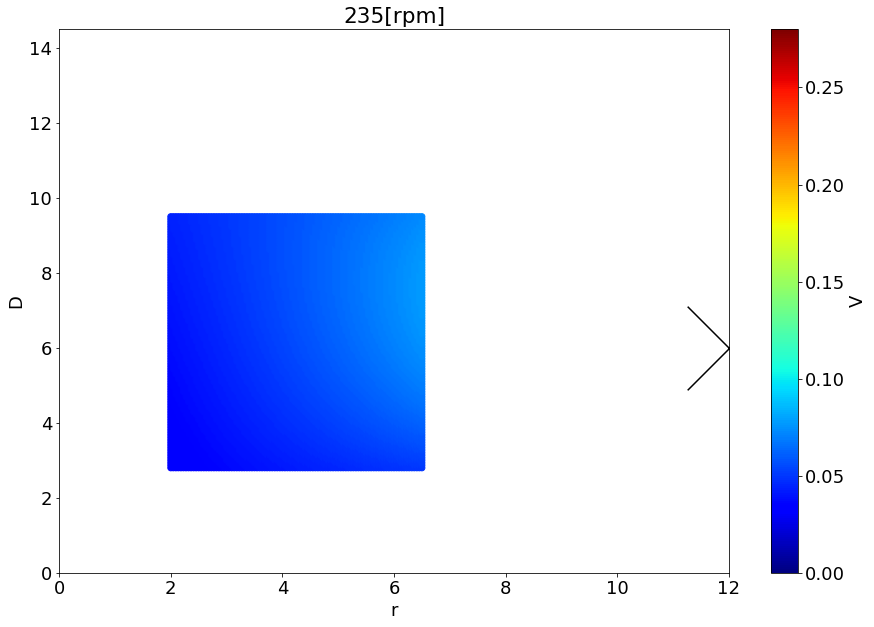

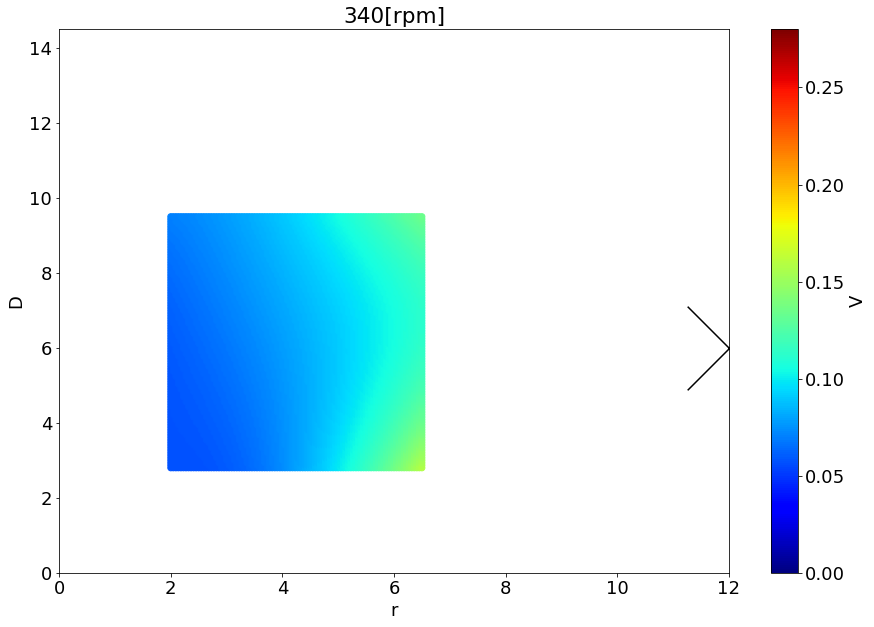

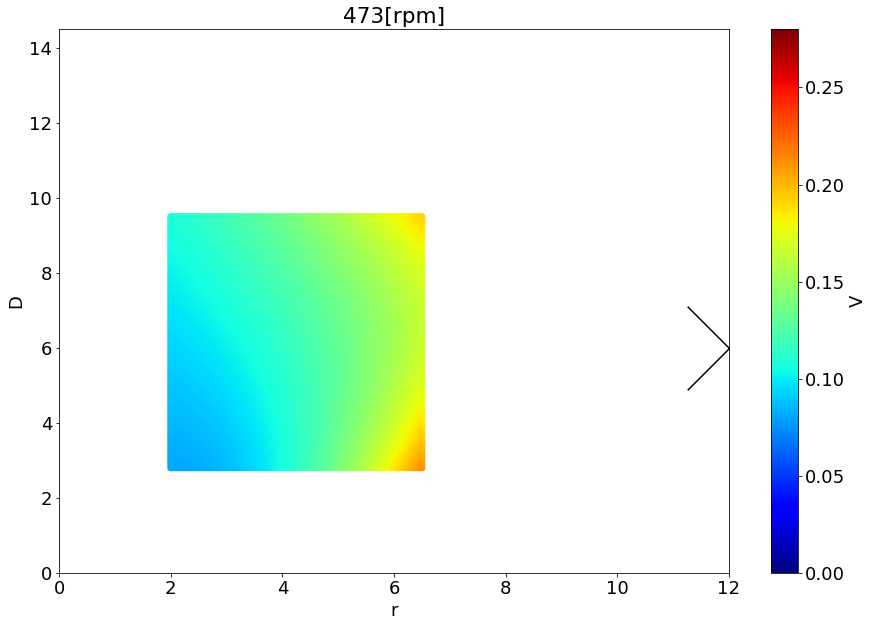

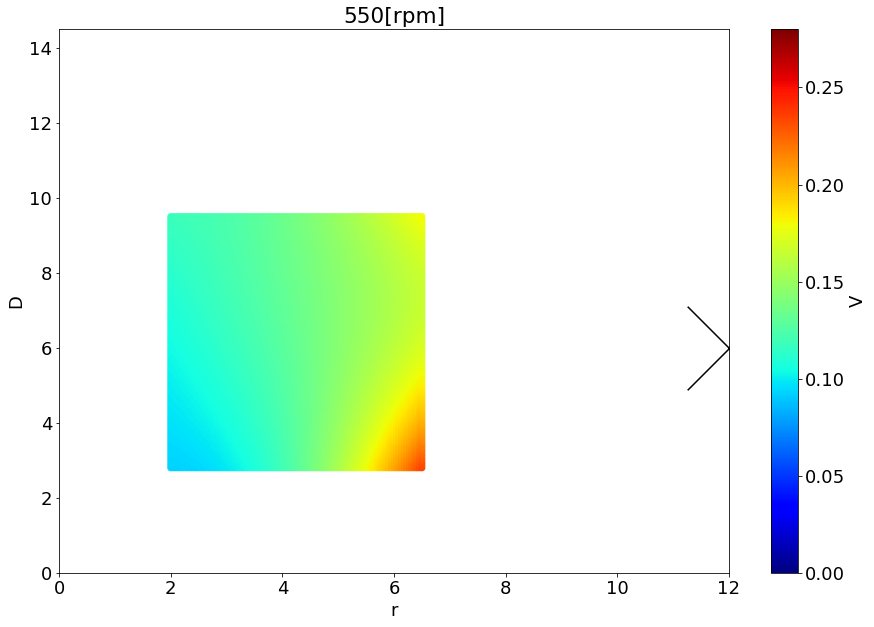

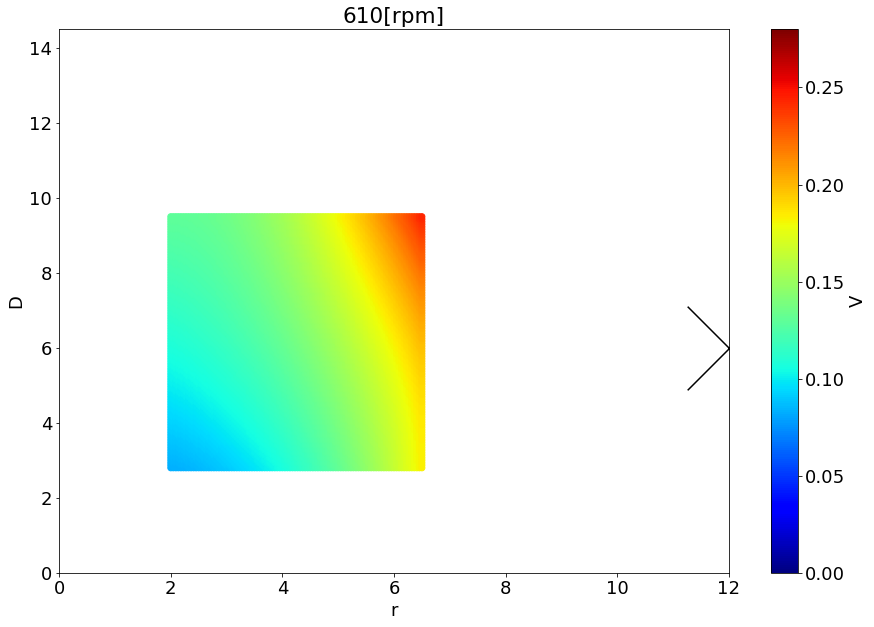

In [11]:
###################
## 格子間の補間 ###
###################

rpm_list = [235, 340, 473, 550, 610]


for rpm in rpm_list:

    vlist = []
    list = []
    D = [2.8, 5.5, 9.5]

    handles = [] # A list of Artists (lines)
    labels = ["D = 2.8", "D = 5.5", "D = 9.5"] 


    ##r方向
    data_2 = data[(data["D"]==2.8) & (data["rpm"]==rpm)]
    data_5 = data[(data["D"]==5.5) & (data["rpm"]==rpm)]
    data_9 = data[(data["D"]==9.5) & (data["rpm"]==rpm)]
    
    #100格子に分割
    x_r_latent = np.linspace(min(data_2['r']), max(data_2['r']), 100)

    #補間
    fitted_curve_2 = interpolate.interp1d(data_2['r'], data_2['V'], kind="quadratic")
    fitted_curve_5 = interpolate.interp1d(data_5['r'], data_5['V'], kind="quadratic")
    fitted_curve_9 = interpolate.interp1d(data_9['r'], data_9['V'], kind="quadratic")


    data_list = [fitted_curve_2(x_r_latent), fitted_curve_5(x_r_latent), fitted_curve_9(x_r_latent)]
    df = pd.DataFrame( data_list, index=["D = 2.8", "D = 5.5", "D = 9.5"] ).T
    df.index = x_r_latent



    ##D方向
    for r in x_r_latent.tolist():

        #100格子に分割
        x_D_latent = np.linspace(min(D), max(D), 100)

        #補間
        fitted_curve = interpolate.interp1d(D, df[df.index == r].values[0], kind="quadratic")
        v = fitted_curve(x_D_latent)

        vlist.append(v.tolist())



    # カラーマップの名前を指定する
    cmap_name = 'jet'

    # カラーマップを取得する
    cmap = plt.get_cmap(cmap_name)


    #CSVに出力    
    for i in range(100):
        for j in range(100):

            list.append([])
            list[i*100+j].append(x_r_latent[i])
            list[i*100+j].append(x_D_latent[j])
            list[i*100+j].append(vlist[i][j])

    df = pd.DataFrame( list, columns = ["r", "D", "V"])
    df.to_csv(fr"C:\Users\vetsa\OneDrive\デスクトップ\seminar related\results\csv\w_speed\est_v\{rpm}.csv")
    
    
    ##データの可視化
    
    # カラーマップの名前を指定する
    cmap_name = 'jet'

    # カラーマップを取得する
    cmap = plt.get_cmap(cmap_name)

    fig = plt.figure(figsize = (15, 10))
    plt.rcParams["font.size"] = 18
    
    plt.scatter(12, 6, c = "black", s = 7000, marker = "x")
    plt.scatter(df["r"], df["D"], c = df["V"], cmap = cmap, vmax = 0.28, vmin = 0)   


    plt.xlim(0,12)
    plt.ylim(0,14.5)    

    plt.xlabel('r')
    plt.ylabel('D')

    plt.title(f'{rpm}[rpm]')

    plt.colorbar(label = "V")
    plt.savefig(fr"C:\Users\vetsa\OneDrive\デスクトップ\seminar related\results\png\est_v\{rpm}.jpg")
    plt.close()

In [13]:
####################
## 速度方向の補間 ##
####################

rpm_list = [235, 340, 473, 550, 610]
files = natsorted(glob.glob(r"C:\Users\vetsa\OneDrive\デスクトップ\seminar related\results\csv\w_speed\est_v\*.csv"))
vlist = []

for i in range(10000):
    
    #376格子に分割
    x_latent = np.linspace(min(rpm_list), max(rpm_list), 376)
    
    #補間
    fitted_curve = interpolate.interp1d(rpm_list, [pd.read_csv(file).iloc[i, 3] for file in files], kind="quadratic")
    v = fitted_curve(x_latent)

    vlist.append(v.tolist())
    
    print(".", end = "")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
list = []

for j in range(376):
    
    #vlistを整理してCSVに出力
    list.append([])
    for i in range(10000):
        list[j].append(vlist[i][j])
    
    df["V"]=list[j]
    df.to_csv(fr"C:\Users\vetsa\OneDrive\デスクトップ\seminar related\results\csv\w_speed\rpm\{int(235+(610-235)/375*j)}.csv")
    
    
    ##データの可視化
    
    # カラーマップの名前を指定する
    cmap_name = 'jet'

    # カラーマップを取得する
    cmap = plt.get_cmap(cmap_name)

    # 散布図を作成する
    
    fig = plt.figure(figsize = (15, 10))
    plt.rcParams["font.size"] = 18
    
    plt.scatter(df["r"], df["D"], c = df["V"], cmap = cmap, vmax = 0.28, vmin = 0, s = 100)   


    plt.xlim(2,6.5)
    plt.ylim(2.8,9.5)    

    plt.xlabel('r')
    plt.ylabel('D')

    plt.title(f'{int(235+(610-235)/375*j)}[rpm]')

    plt.colorbar(label = "V")
    plt.savefig(fr"C:\Users\vetsa\OneDrive\デスクトップ\seminar related\results\png\w_speed\{j+1}.jpg")      
    plt.close()

In [17]:
###################
## GIF画像の作成 ##
###################

from PIL import Image
import os
import glob
 
d_list = [50] * 376
d_list[0]=500
d_list[-1]=700

# GIFアニメーションを作成
def create_gif(in_dir, out_filename):
    path_list = natsorted(glob.glob(r"C:\Users\vetsa\OneDrive\デスクトップ\seminar related\results\png\w_speed\*.jpg")) # ファイルパスをソートしてリストする
    imgs = []                                                   # 画像をappendするための空配列を定義
 
    # ファイルのフルパスからファイル名と拡張子を抽出
    for i in range(len(path_list)):
        img = Image.open(path_list[i])                          # 画像ファイルを1つずつ開く
        imgs.append(img)                                        # 画像をappendで配列に格納していく
 
    # appendした画像配列をGIFにする。durationで持続時間、loopでループ数を指定可能。
    imgs[0].save(out_filename,
                 save_all=True, append_images=imgs[1:], optimize=False, duration=d_list, loop=0)
 
#GIFアニメーションを作成する関数を実行する
create_gif(in_dir='input', out_filename=r"C:\Users\vetsa\OneDrive\デスクトップ\seminar related\results\png\w_speed\w_speed.gif")